# Classifying Images with pre-built TF Container on Vertex AI

## Introduction

In this notebook, you learn how to implement different image models on MNIST using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras).

## Learning objectives
1. Understand how to build a Dense Neural Network (DNN) for image classification.
2. Understand how to use dropout (DNN) for image classification.
3. Understand how to use Convolutional Neural Networks (CNN).
4. Know how to deploy and use an image classifcation model using Google Cloud's [Vertex AI](https://cloud.google.com/vertex-ai/).

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/classifying_images_with_pre-built_tf_container_on_vertex_ai.ipynb) -- try to complete that notebook first before reviewing this solution notebook.


## Configuring the parameters

First, configure the parameters below to match your own Google Cloud project details.
If you don’t want to change the region, leave all settings as they are. Otherwise, update the region as you want, leave other settings as they are and run the cell.

In [2]:
from datetime import datetime
import os

REGION = 'us-central1'
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET =  PROJECT
MODEL_TYPE = "cnn"  # "linear", "dnn", "dnn_dropout", or "cnn"

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["MODEL_TYPE"] = MODEL_TYPE

## Building a dynamic model

This part of notebook demonstrates how to implement DNN and CNN models on [MNIST](http://yann.lecun.com/exdb/mnist/) using the [tf.keras API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras). 

In the previous notebook, “[classifying_images_with_a_nn_and_dnn_model.ipynb](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/computer_vision_fun/solutions/classifying_images_with_a_nn_and_dnn_model.ipynb)”, you run the code directly from the notebook. In this notebook, you see that you can also package your notebook as a python module on Vertex AI.

The boilerplate structure for this module has already been set up in the folder mnist_models. The module lives in the sub-folder, trainer, and is designated as a python package with the empty __init__.py (mnist_models/trainer/__init__.py) file. It still needs the model and a trainer to run it, so let's make them.

Start with the trainer file first. This file parses command line arguments to feed into the model.

In [3]:
%%writefile mnist_models/trainer/task.py
import argparse
import json
import os
import sys

from . import model


def _parse_arguments(argv):
    """Parses command-line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--model_type',
        help='Which model type to use',
        type=str, default='linear')
    parser.add_argument(
        '--epochs',
        help='The number of epochs to train',
        type=int, default=10)
    parser.add_argument(
        '--steps_per_epoch',
        help='The number of steps per epoch to train',
        type=int, default=100)
    parser.add_argument(
        '--job-dir',
        help='Directory where to save the given model',
        type=str, default='mnist_models/')
    return parser.parse_known_args(argv)


def main():
    """Parses command line arguments and kicks off model training."""
    args = _parse_arguments(sys.argv[1:])[0]

    # Configure path for hyperparameter tuning.
    trial_id = json.loads(
        os.environ.get('TF_CONFIG', '{}')).get('task', {}).get('trial', '')
    output_path = args.job_dir if not trial_id else args.job_dir + '/'

    model_layers = model.get_layers(args.model_type)
    image_model = model.build_model(model_layers, args.job_dir)
    model_history = model.train_and_evaluate(
        image_model, args.epochs, args.steps_per_epoch, args.job_dir)


if __name__ == '__main__':
    main()


Writing mnist_models/trainer/task.py


Next, group non-model functions into a util file to keep the model file simple. Use the scale and load_dataset functions to scale images from a 0-255 int range to a 0-1 float range and load MNIST dataset into a tf.data.Dataset.

In [4]:
%%writefile mnist_models/trainer/util.py
import tensorflow as tf


def scale(image, label):
    """Scales images from a 0-255 int range to a 0-1 float range"""
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.expand_dims(image, -1)
    return image, label


def load_dataset(
        data, training=True, buffer_size=5000, batch_size=100, nclasses=10):
    """Loads MNIST dataset into a tf.data.Dataset"""
    (x_train, y_train), (x_test, y_test) = data
    x = x_train if training else x_test
    y = y_train if training else y_test
    # One-hot encode the classes
    y = tf.keras.utils.to_categorical(y, nclasses)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(scale).batch(batch_size)
    if training:
        dataset = dataset.shuffle(buffer_size).repeat()
    return dataset


Writing mnist_models/trainer/util.py


Now you can code the models. The tf.keras API accepts an array of layers into a model object, so you can create a dictionary of layers based on the different model types you want to use. mnist_models/trainer/model.py file has three functions: get_layers, build_model and train_and_evaluate. 

In get_layers function: Youl build the structure of our model in get_layers with four different layers:

* First, you define a linear model.
* Second, you define the Keras layers for a DNN model.
* Third, you define the Keras layers for a dropout model.
* Lastly, you define the Keras layers for a CNN model.

In the build_model function: You compile the model, specifying an optimizer to use, the loss to minimize, and metrics to report. 

Finally in the train_and_evaluate function, you compile your Keras model by loading data into it for training.

Note that these models progressively build on each other. Look at the imported tensorflow.keras.layers modules and the default values for the variables defined in get_layers for guidance.

In [5]:
%%writefile mnist_models/trainer/model.py
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)

from . import util


# Image Variables
WIDTH = 28
HEIGHT = 28


def get_layers(
        model_type,
        nclasses=10,
        hidden_layer_1_neurons=400,
        hidden_layer_2_neurons=100,
        dropout_rate=0.25,
        num_filters_1=64,
        kernel_size_1=3,
        pooling_size_1=2,
        num_filters_2=32,
        kernel_size_2=3,
        pooling_size_2=2):
    """Constructs layers for a keras model based on a dict of model types."""
    model_layers = {
        'linear': [
            Flatten(),
            Dense(nclasses),
            Softmax()
        ],
        # TODO 1: Define the Keras layers for a DNN model
        'dnn': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dense(nclasses),
            Softmax()
        ],
        # TODO 2: Define the Keras layers for a dropout model
        'dnn_dropout': [
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ],
        # TODO 3: Define the Keras layers for a CNN model
        'cnn': [
            Conv2D(num_filters_1, kernel_size=kernel_size_1,
                   activation='relu', input_shape=(WIDTH, HEIGHT, 1)),
            MaxPooling2D(pooling_size_1),
            Conv2D(num_filters_2, kernel_size=kernel_size_2,
                   activation='relu'),
            MaxPooling2D(pooling_size_2),
            Flatten(),
            Dense(hidden_layer_1_neurons, activation='relu'),
            Dense(hidden_layer_2_neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(nclasses),
            Softmax()
        ]
    }
    return model_layers[model_type]


def build_model(layers, output_dir):
    """Compiles keras model for image classification."""
    model = Sequential(layers)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def train_and_evaluate(model, num_epochs, steps_per_epoch, output_dir):
    """Compiles keras model and loads data into it for training."""
    mnist = tf.keras.datasets.mnist.load_data()
    train_data = util.load_dataset(mnist)
    validation_data = util.load_dataset(mnist, training=False)

    callbacks = []
    if output_dir:
        tensorboard_callback = TensorBoard(log_dir=output_dir)
        callbacks = [tensorboard_callback]

    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=2,
        callbacks=callbacks)

    if output_dir:
        export_path = os.path.join(output_dir, 'keras_export')
        model.save(export_path, save_format='tf')

    return history

Writing mnist_models/trainer/model.py


## Local Training

After completing the set up, you can run locally to test the code. Some of the previous tests have been copied over into a testing script mnist_models/trainer/test.py to make sure the model still passes our previous checks. On line 13, you can specify which model types you would like to check. line 14 and line 15 have the number of epochs and steps per epoch respectively.

Run the code below to check your models against the unit tests. If you see "OK" at the end when it's finished running, congrats! You've passed the tests!

In [6]:
!python3 -m mnist_models.trainer.test

2024-06-18 16:42:34.610321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-06-18 16:42:34.610371: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-18 16:42:34.610402: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240618-191717): /proc/driver/nvidia/version does not exist
2024-06-18 16:42:34.610762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
20

Now you know that your models are working as expected. Now ,you can run it on Google Cloud within Vertex AI. You can run it as a python module locally first using the command line.

The below cell transfers some of your variables to the command line and creates a job directory including a timestamp.

In [7]:
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
model_type = 'cnn'

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "mnist_models/models/{}_{}/".format(
    model_type, current_time)

The cell below runs the local version of the code. The epochs and steps_per_epoch flag can be changed to run for longer or shorter, as defined in your mnist_models/trainer/task.py file.

In [8]:
%%bash
python3 -m mnist_models.trainer.task \
    --job-dir=$JOB_DIR \
    --epochs=5 \
    --steps_per_epoch=50 \
    --model_type=$MODEL_TYPE

2024-06-18 16:44:24.718938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-06-18 16:44:24.718979: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-18 16:44:24.719009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240618-191717): /proc/driver/nvidia/version does not exist
2024-06-18 16:44:24.719321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
20

Epoch 1/5
50/50 - 9s - loss: 1.0263 - accuracy: 0.6770 - val_loss: 0.3354 - val_accuracy: 0.9051
Epoch 2/5
50/50 - 4s - loss: 0.2752 - accuracy: 0.9196 - val_loss: 0.1899 - val_accuracy: 0.9422
Epoch 3/5
50/50 - 4s - loss: 0.2345 - accuracy: 0.9322 - val_loss: 0.1216 - val_accuracy: 0.9630
Epoch 4/5
50/50 - 4s - loss: 0.1712 - accuracy: 0.9474 - val_loss: 0.1030 - val_accuracy: 0.9700
Epoch 5/5
50/50 - 4s - loss: 0.1438 - accuracy: 0.9534 - val_loss: 0.0967 - val_accuracy: 0.9689


2024-06-18 16:45:07.343062: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Training on the cloud

For this model, you use a Tensorflow pre-built container on Vertex AI, as you do not have any particular additional prerequisites. You use setuptools for this, and store the created source distribution on Cloud Storage by using “**gsutil cp**”.

In [9]:
%%writefile mnist_models/setup.py
from setuptools import find_packages
from setuptools import setup

setup(
    name='mnist_trainer',
    version='0.1',
    packages=find_packages(),
    include_package_data=True,
    description='MNIST model training application.'
)

Writing mnist_models/setup.py


In [10]:
%%bash
cd mnist_models
python ./setup.py sdist --formats=gztar
cd ..
gsutil cp mnist_models/dist/mnist_trainer-0.1.tar.gz gs://${BUCKET}/mnist/

running sdist
running egg_info
creating mnist_trainer.egg-info
writing mnist_trainer.egg-info/PKG-INFO
writing dependency_links to mnist_trainer.egg-info/dependency_links.txt
writing top-level names to mnist_trainer.egg-info/top_level.txt
writing manifest file 'mnist_trainer.egg-info/SOURCES.txt'
reading manifest file 'mnist_trainer.egg-info/SOURCES.txt'
writing manifest file 'mnist_trainer.egg-info/SOURCES.txt'


running check
creating mnist_trainer-0.1
creating mnist_trainer-0.1/mnist_trainer.egg-info
creating mnist_trainer-0.1/trainer
copying files to mnist_trainer-0.1...
copying setup.py -> mnist_trainer-0.1
copying mnist_trainer.egg-info/PKG-INFO -> mnist_trainer-0.1/mnist_trainer.egg-info
copying mnist_trainer.egg-info/SOURCES.txt -> mnist_trainer-0.1/mnist_trainer.egg-info
copying mnist_trainer.egg-info/dependency_links.txt -> mnist_trainer-0.1/mnist_trainer.egg-info
copying mnist_trainer.egg-info/top_level.txt -> mnist_trainer-0.1/mnist_trainer.egg-info
copying trainer/__init__.py -> mnist_trainer-0.1/trainer
copying trainer/model.py -> mnist_trainer-0.1/trainer
copying trainer/task.py -> mnist_trainer-0.1/trainer
copying trainer/test.py -> mnist_trainer-0.1/trainer
copying trainer/util.py -> mnist_trainer-0.1/trainer
copying mnist_trainer.egg-info/SOURCES.txt -> mnist_trainer-0.1/mnist_trainer.egg-info
Writing mnist_trainer-0.1/setup.cfg
creating dist
Creating tar archive
removing 'mnis

Copying file://mnist_models/dist/mnist_trainer-0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  3.4 KiB/  3.4 KiB]                                                
Operation completed over 1 objects/3.4 KiB.                                      


Then, you can start the Vertex AI Custom Job using the pre-built container. You can pass your source distribution URI using the --python-package-uris flag.

In [11]:
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
model_type = 'cnn'

os.environ["MODEL_TYPE"] = model_type
os.environ["JOB_DIR"] = "gs://{}/mnist_{}_{}/".format(
    BUCKET, model_type, current_time)
os.environ["JOB_NAME"] = "mnist_{}_{}".format(
    model_type, current_time)

After submitting the following job, view the status in __Vertex AI__ > __Training__ and select __Custom Jobs__ tab. Wait for the job to finish.

In [12]:
%%bash
echo $JOB_DIR $REGION $JOB_NAME

PYTHON_PACKAGE_URIS=gs://${BUCKET}/mnist/mnist_trainer-0.1.tar.gz
MACHINE_TYPE=n1-standard-4
REPLICA_COUNT=1
PYTHON_PACKAGE_EXECUTOR_IMAGE_URI="us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-3:latest"
PYTHON_MODULE=trainer.task
    
WORKER_POOL_SPEC="machine-type=$MACHINE_TYPE,\
replica-count=$REPLICA_COUNT,\
executor-image-uri=$PYTHON_PACKAGE_EXECUTOR_IMAGE_URI,\
python-module=$PYTHON_MODULE"

gcloud ai custom-jobs create \
  --region=${REGION} \
  --display-name=$JOB_NAME \
  --python-package-uris=$PYTHON_PACKAGE_URIS \
  --worker-pool-spec=$WORKER_POOL_SPEC \
  --args="--job-dir=$JOB_DIR,--model_type=$MODEL_TYPE"

gs://qwiklabs-gcp-02-30772803563a/mnist_cnn_20240618_164510/ us-central1 mnist_cnn_20240618_164510


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
CustomJob [projects/946485325062/locations/us-central1/customJobs/1576185961782444032] is submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud ai custom-jobs describe projects/946485325062/locations/us-central1/customJobs/1576185961782444032

or continue streaming the logs with the command

  $ gcloud ai custom-jobs stream-logs projects/946485325062/locations/us-central1/customJobs/1576185961782444032


In [13]:
%%bash
SAVEDMODEL_DIR=${JOB_DIR}keras_export
echo $SAVEDMODEL_DIR
gsutil ls $SAVEDMODEL_DIR

gs://qwiklabs-gcp-02-30772803563a/mnist_cnn_20240618_164510/keras_export


CommandException: One or more URLs matched no objects.


CalledProcessError: Command 'b'SAVEDMODEL_DIR=${JOB_DIR}keras_export\necho $SAVEDMODEL_DIR\ngsutil ls $SAVEDMODEL_DIR\n'' returned non-zero exit status 1.

## Deploying and predicting with model

Once you have a model you're proud of, let's deploy it! All you need to do is to upload the created model artifact from Cloud Storage to Vertex AI as a model, create a new endpoint, and deploy the model to the endpoint. It can take 15-20 minutes to complete. Make a note of **ENDPOINT_RESOURCENAME** for further use.

In [14]:
%%bash
TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)
MODEL_DISPLAYNAME=mnist_$TIMESTAMP
ENDPOINT_DISPLAYNAME=mnist_endpoint_$TIMESTAMP
IMAGE_URI="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest"
SAVEDMODEL_DIR=${JOB_DIR}keras_export
echo $SAVEDMODEL_DIR

# Model
MODEL_RESOURCENAME=$(gcloud ai models upload \
    --region=$REGION \
    --display-name=$MODEL_DISPLAYNAME \
    --container-image-uri=$IMAGE_URI \
    --artifact-uri=$SAVEDMODEL_DIR \
    --format="value(model)")

echo "MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}"
echo "MODEL_RESOURCENAME=${MODEL_RESOURCENAME}"

# Endpoint
ENDPOINT_RESOURCENAME=$(gcloud ai endpoints create \
  --region=$REGION \
  --display-name=$ENDPOINT_DISPLAYNAME \
  --format="value(name)")

echo "ENDPOINT_DISPLAYNAME=${ENDPOINT_DISPLAYNAME}"
echo "ENDPOINT_RESOURCENAME=${ENDPOINT_RESOURCENAME}"

# Deployment
DEPLOYED_MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}_deployment
MACHINE_TYPE=n1-standard-2

gcloud ai endpoints deploy-model $ENDPOINT_RESOURCENAME \
  --region=$REGION \
  --model=$MODEL_RESOURCENAME \
  --display-name=$DEPLOYED_MODEL_DISPLAYNAME \
  --machine-type=$MACHINE_TYPE \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-02-30772803563a/mnist_cnn_20240618_164510/keras_export


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
ERROR: (gcloud.ai.models.upload) NOT_FOUND: There are no files in directory "gs://qwiklabs-gcp-02-30772803563a/mnist_cnn_20240618_164510/keras_export". Please check if the Cloud Storage URI is correct or copy at least one file to the directory.


MODEL_DISPLAYNAME=mnist_20240618_164527
MODEL_RESOURCENAME=


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2968051684070129664]...
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ENDPOINT_DISPLAYNAME=mnist_endpoint_20240618_164527
ENDPOINT_RESOURCENAME=projects/946485325062/locations/us-central1/endpoints/108242521708036096


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
ERROR: (gcloud.ai.endpoints.deploy-model) could not parse resource []


CalledProcessError: Command 'b'TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)\nMODEL_DISPLAYNAME=mnist_$TIMESTAMP\nENDPOINT_DISPLAYNAME=mnist_endpoint_$TIMESTAMP\nIMAGE_URI="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest"\nSAVEDMODEL_DIR=${JOB_DIR}keras_export\necho $SAVEDMODEL_DIR\n\n# Model\nMODEL_RESOURCENAME=$(gcloud ai models upload \\\n    --region=$REGION \\\n    --display-name=$MODEL_DISPLAYNAME \\\n    --container-image-uri=$IMAGE_URI \\\n    --artifact-uri=$SAVEDMODEL_DIR \\\n    --format="value(model)")\n\necho "MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}"\necho "MODEL_RESOURCENAME=${MODEL_RESOURCENAME}"\n\n# Endpoint\nENDPOINT_RESOURCENAME=$(gcloud ai endpoints create \\\n  --region=$REGION \\\n  --display-name=$ENDPOINT_DISPLAYNAME \\\n  --format="value(name)")\n\necho "ENDPOINT_DISPLAYNAME=${ENDPOINT_DISPLAYNAME}"\necho "ENDPOINT_RESOURCENAME=${ENDPOINT_RESOURCENAME}"\n\n# Deployment\nDEPLOYED_MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}_deployment\nMACHINE_TYPE=n1-standard-2\n\ngcloud ai endpoints deploy-model $ENDPOINT_RESOURCENAME \\\n  --region=$REGION \\\n  --model=$MODEL_RESOURCENAME \\\n  --display-name=$DEPLOYED_MODEL_DISPLAYNAME \\\n  --machine-type=$MACHINE_TYPE \\\n  --min-replica-count=1 \\\n  --max-replica-count=1 \\\n  --traffic-split=0=100\n'' returned non-zero exit status 1.

To predict with the model, take one of the example images.

Write a .json file with image data to send to a Vertex AI deployed model.

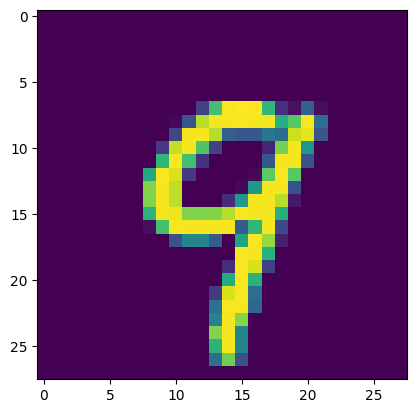

In [15]:
import json, codecs
import tensorflow as tf
import matplotlib.pyplot as plt

HEIGHT = 28
WIDTH = 28
IMGNO = 12

mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist
test_image = x_test[IMGNO]

# TODO 4: Prepare jsondata
jsondata = {"instances": [
    test_image.reshape(HEIGHT, WIDTH, 1).tolist()
]}
json.dump(jsondata, codecs.open("test.json", "w", encoding = "utf-8"))
plt.imshow(test_image.reshape(HEIGHT, WIDTH));

In [16]:
!cat test.json

{"instances": [[[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [

Finally, you can send it to the prediction service. The output will have a 1 in the index of the corresponding digit it is predicting. Congrats! You've completed the lab!

In [17]:
%%bash
ENDPOINT_RESOURCENAME=#Insert ENDPOINT_RESOURCENAME from above

gcloud ai endpoints predict $ENDPOINT_RESOURCENAME \
    --region=$REGION \
    --json-request=test.json

bash: line 1: ENDPOINT_RESOURCENAME: command not found
ERROR: (gcloud.ai.endpoints.predict) argument --region: ENDPOINT must be specified.
Usage: gcloud ai endpoints predict (ENDPOINT : --region=REGION) --json-request=JSON_REQUEST [optional flags]
  optional flags may be  --help | --region

For detailed information on this command and its flags, run:
  gcloud ai endpoints predict --help


CalledProcessError: Command 'b'ENDPOINT_RESOURCENAME=#Insert ENDPOINT_RESOURCENAME from above\n\ngcloud ai endpoints predict $ENDPOINT_RESOURCENAME \\\n    --region=$REGION \\\n    --json-request=test.json\n'' returned non-zero exit status 2.

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.